<a href="https://colab.research.google.com/github/maracasabat/Data-Science-HW9/blob/main/Hw_9_tensorflow_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завдання ми створимо повнозв'язкову нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектутра нейромережі представлена ​​на наступному малюнку. Як бачите, в ній є один вхідний шар, два приховані, а так само вихідний шар. Як активаційну функцію в прихованих шарах буде використовуватися сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду створення мережі вже написана, від вас потрібно заповнити пропуски в зазначених місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми навчатимемо на датасеті MNIST. Цей датасет є великою кількістю зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель набуває значення від 0 до 255.

Як і раніше датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилися у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Крім того, архітектура нейронної мережі очікує на вхід вектор. У нашому випадку кожен об'єкт вибірки є матрицею. Що ж робити? У цьому завдання ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28*28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальна кількість епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковому підтримці з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат та точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [4]:
from tensorflow.keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворимо цілочисленні пікселі до типу float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворимо цілочисленні пікселі до типу float32
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 10s 1us/step


In [37]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, що складається із 128 нейронів.
    self.layer_1 = DenseLayer(num_features, n_hidden_1, name="layer_1")

 #Місце вашого коду

    # Другий шар, що складається з 256 нейронів
    self.layer_2 =   DenseLayer(n_hidden_1, n_hidden_2, name="layer_2") #Місце вашого коду

    # Вихідний шар
    self.layer_3 = DenseLayer(n_hidden_2, num_classes, name="layer_3")#Місце вашого коду

  def __call__(self, x):
    # Місце для вашого коду
    x1 = self.layer_1(x, activation=1) #Місце вашого коду
    x2 = self.layer_2(x1, activation=1)#Місце вашого коду
    x3 =self.layer_3(x2, activation=1) #Місце вашого коду

    # Пам'ятайте, що для виходу нейронної мережі ми застосовуємо до виходу функцію softmax.
    # Робимо ми це для того, щоб
    # вихід нейронної мережі приймав значення від 0 до 1 відповідно до ймовірності
    # Приналежності вхідного об'єкта до одного з 10 класів

    return tf.nn.softmax(x3)

In [38]:
# Як функцію помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    preds = tf.argmax(y_pred, axis=1)

    acc =tf.keras.metrics.Accuracy() #Місце вашого коду
    acc.update_state(y_true, preds)
    return acc.result()

In [39]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(nn, input_x, output_y):
  # Для припасування ваг мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Створимо список параметрів, що оптимізуються.
    trainable_variables = neural_net.trainable_variables #Місце вашого коду
    # Обчислимо за ними значення градієнта
    gradients =  g.gradient(loss, trainable_variables)#Місце вашого коду
    
    # Модифікуємо параметри
    #Місце вашого коду
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    

In [40]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігайте в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігайте в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# з тренувального датасету train_data вийміть випадкову підмножину, на якій
# відбудеться тренування. Використовуйте метод take, доступний для тренувального датасету.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Оновлюємо ваги нейронної мережі
    # Місце вашого коду
    loss = train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        #Місце вашого коду
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print("Step {}, loss={:.4f}, accuracy={:.4f}".format(step, loss, acc))

Step 0, loss=589.7755, accuracy=0.1172
Step 100, loss=589.3005, accuracy=0.1406
Step 200, loss=589.4169, accuracy=0.1406
Step 300, loss=589.1656, accuracy=0.1445
Step 400, loss=589.6698, accuracy=0.1094
Step 500, loss=589.6149, accuracy=0.1016
Step 600, loss=589.7018, accuracy=0.0898
Step 700, loss=589.1818, accuracy=0.1406
Step 800, loss=589.4740, accuracy=0.0820
Step 900, loss=589.1922, accuracy=0.1289
Step 1000, loss=589.0990, accuracy=0.1172
Step 1100, loss=589.3763, accuracy=0.1016
Step 1200, loss=588.7018, accuracy=0.1523
Step 1300, loss=588.8359, accuracy=0.1328
Step 1400, loss=589.4097, accuracy=0.1055
Step 1500, loss=589.4666, accuracy=0.1094
Step 1600, loss=588.7954, accuracy=0.1250
Step 1700, loss=588.5021, accuracy=0.1484
Step 1800, loss=588.7887, accuracy=0.1211
Step 1900, loss=589.6688, accuracy=0.0820
Step 2000, loss=589.5629, accuracy=0.0977
Step 2100, loss=588.9154, accuracy=0.1211
Step 2200, loss=588.7567, accuracy=0.1289
Step 2300, loss=589.4463, accuracy=0.1016
Step

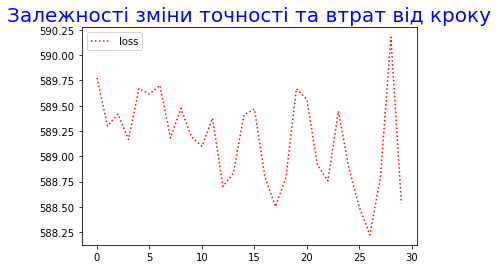

In [41]:
# Виведіть графіки залежності зміни точності та втрат від кроку
# Якщо все зроблено правильно, то точність має зростати, а втрати зменшуватися

plt.plot(loss_history, 'r', label='loss', linestyle=":")
plt.legend()

plt.title("Залежності зміни точності та втрат від кроку", fontsize=20, color='b')
plt.show()

In [42]:
# Обчисліть точність навченої нейромережі
neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {neural_net_accuracy}")


Accuracy: 0.11236666887998581


True: 3 Predict: 1 False
True: 1 Predict: 1 True
True: 8 Predict: 1 False
True: 2 Predict: 1 False
True: 1 Predict: 1 True
True: 4 Predict: 1 False
True: 1 Predict: 1 True
True: 6 Predict: 1 False
True: 9 Predict: 1 False
True: 7 Predict: 1 False


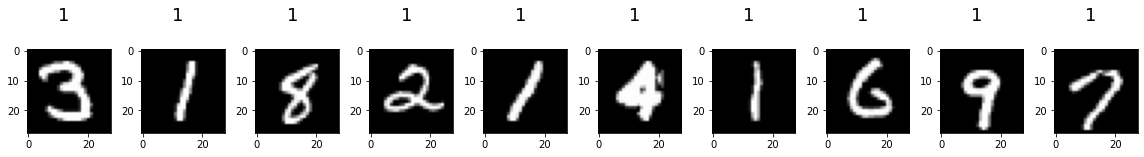

In [50]:
# Протестуємо навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється ваша нейронна мережа і якщо так, то як часто?
test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(16, 6))
for i in range(10):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)
    
plt.tight_layout()
plt.show()


In [ ]:
# Висновок моя мережа не показує похибок, але є прблема в тому, що вона не знахоть значення самої цифри, у неї є одна
# зазначенна цифра- це 1 та цю цифру вона і шукає, якщо на картинці 1 - вона пише True,якщо ні, то False